# MODNet 'matbench_steels' benchmarking

The `matbench_steels` dataset from [Citrination](https://citrination.com/datasets/153092/) (contributed by Gareth Conduit, University of Cambridge) contains the composition of ~800 steels and some measured properties with variable coverage. The dataset `matbench_steels` as made available by matminer has de-duplicated the steels down to ~312 samples, and provides only the measured yield strength, the property with 100% coverage.

In [1]:
from collections import defaultdict
import itertools
import os
import pandas as pd
import matplotlib.pyplot as plt 
import numpy as np
from matminer.datasets import load_dataset
from pymatgen.core import Composition

from modnet.preprocessing import MODData
from modnet.models import MODNetModel
from modnet.featurizers import MODFeaturizer
from modnet.featurizers.presets import DeBreuck2020Featurizer

os.environ["CUDA_VISIBLE_DEVICES"] = "0"


If you use the ChemEnv tool for your research, please consider citing the following reference(s) :
David Waroquiers, Xavier Gonze, Gian-Marco Rignanese, Cathrin Welker-Nieuwoudt, Frank Rosowski,
Michael Goebel, Stephan Schenk, Peter Degelmann, Rute Andre, Robert Glaum, and Geoffroy Hautier,
"Statistical analysis of coordination environments in oxides",
Chem. Mater., 2017, 29 (19), pp 8346-8360,
DOI: 10.1021/acs.chemmater.7b02766



## Data exploration

In [2]:
df = load_dataset("matbench_steels")
df["composition"] = df["composition"].map(Composition)

In [3]:
df.columns

Index(['composition', 'yield strength'], dtype='object')

### Composition space

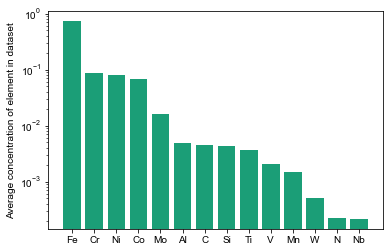

In [4]:
values = df["composition"].apply(lambda s: s.get_el_amt_dict())
elements = defaultdict(float)
proportions = defaultdict(list)
for s in values:
    for e in s:
        elements[e] += s[e]
        proportions[e] += [s[e]]
        
for elem in elements:
    elements[elem] /= len(values)

mean_proportions = {elem: np.mean(proportions[elem]) for elem in proportions}
mean_proportions = dict(sorted(mean_proportions.items(), key=lambda x: x[1], reverse=True))
elements = dict(sorted(elements.items(), key=lambda x: x[1], reverse=True))

fig, ax = plt.subplots(facecolor="w");
ax.set_yscale("log")
ax.bar(elements.keys(), elements.values())
ax.set_ylabel("Average concentration of element in dataset");

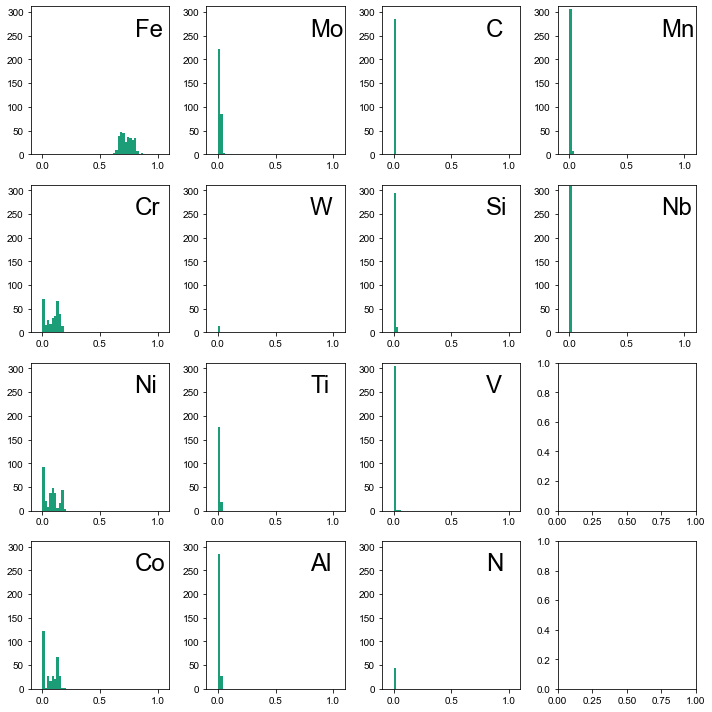

In [5]:
# distribution of element proportions across compositions
fig, ax = plt.subplots(4, 4, facecolor="w", figsize=(10, 10))
for axis, elem in zip(itertools.product(range(0, 4), repeat=2), mean_proportions):
    axis = (axis[1], axis[0])
    ax[axis].hist(
        proportions[elem], 
        bins=np.linspace(0, 1, 50), 
        density=False, 
    )
    ax[axis].set_xlim(-0.1, 1.1)
    ax[axis].text(0.75, 0.8, elem, fontsize=24, transform=ax[axis].transAxes, )
    ax[axis].set_ylim(0, 312)

plt.tight_layout()

### Target space

In [6]:
df.describe()

,yield strength
count,312.000000
mean,1420.998397
std,301.894169
min,1005.900000
25%,1219.475000
50%,1344.200000
75%,1576.075000
max,2510.300000


Text(0.5, 0, 'Yield strength (GPa)')

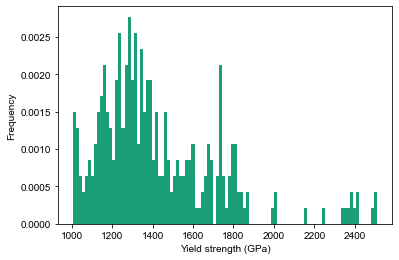

In [7]:
fig, ax = plt.subplots(facecolor="w")
ax.hist(df["yield strength"], bins=100, density=True);
ax.set_ylabel("Frequency")
ax.set_xlabel("Yield strength (GPa)")

## Featurization and feature selection

First, we define some convenience classes that pass wraps composition data in a fake structure containe, and we define a composition only featurizer preset based on `DeBreuck2020Featurizer`.

In [2]:
class CompositionOnlyFeaturizer(MODFeaturizer):
    composition_featurizers = DeBreuck2020Featurizer.composition_featurizers
    
    def featurize_composition(self, df):
        """ Applies the preset composition featurizers to the input dataframe,
        renames some fields and cleans the output dataframe.

        """
        from pymatgen.core.periodic_table import Element 
        import numpy as np
        from modnet.featurizers import clean_df
        df = super().featurize_composition(df)
        _orbitals = {"s": 1, "p": 2, "d": 3, "f": 4}
        df['AtomicOrbitals|HOMO_character'] = df['AtomicOrbitals|HOMO_character'].map(_orbitals)
        df['AtomicOrbitals|LUMO_character'] = df['AtomicOrbitals|LUMO_character'].map(_orbitals)

        df['AtomicOrbitals|HOMO_element'] = df['AtomicOrbitals|HOMO_element'].apply(
            lambda x: -1 if not isinstance(x, str) else Element(x).Z
        )
        df['AtomicOrbitals|LUMO_element'] = df['AtomicOrbitals|LUMO_element'].apply(
            lambda x: -1 if not isinstance(x, str) else Element(x).Z
        )

        df = df.replace([np.inf, -np.inf, np.nan], 0)
        
        return clean_df(df)

class CompositionContainer:
    def __init__(self, composition):
        self.composition = composition

In [3]:
PRECOMPUTED_MODDATA = "./precomputed/steel_benchmark_moddata.pkl.gz"

if os.path.isfile(PRECOMPUTED_MODDATA):
    data = MODData.load(PRECOMPUTED_MODDATA)
else:
    # Use a fresh copy of the dataset
    df = load_dataset("matbench_steels")
    df["composition"] = df["composition"].map(Composition)
    df["structure"] = df["composition"].map(CompositionContainer)
    
    data = MODData(
        structures=df["structure"].tolist(), 
        targets=df["yield strength"].tolist(), 
        target_names=["yield strength (MPa)"],
        featurizer=CompositionOnlyFeaturizer(n_jobs=8)
    )
    data.featurize()
    # As this is a small data/feature set, order all features 
    data.feature_selection(n=-1)

INFO:root:Loaded <modnet.preprocessing.MODData object at 0x7f0cb3f49760> object, created with modnet version 0.1.8~develop


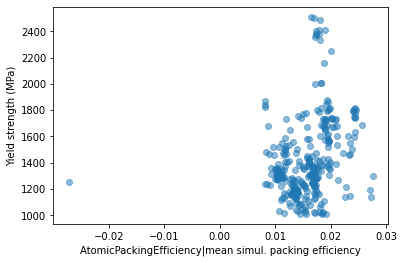

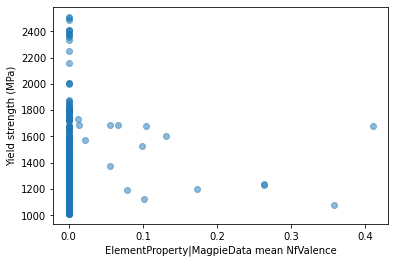

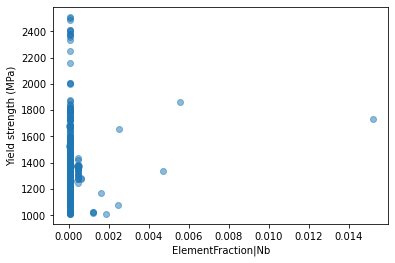

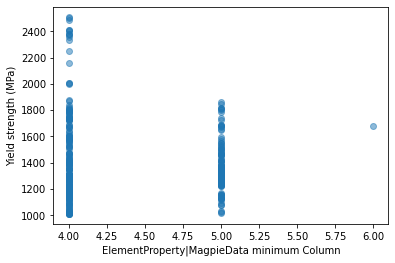

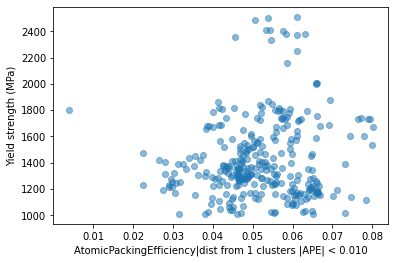

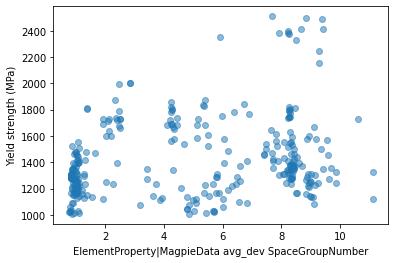

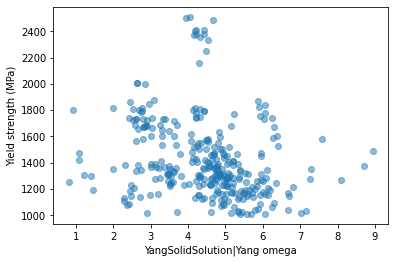

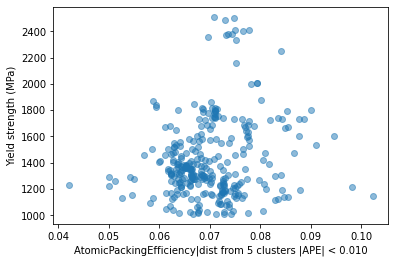

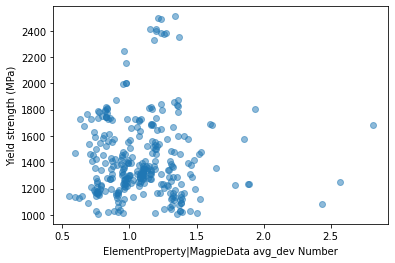

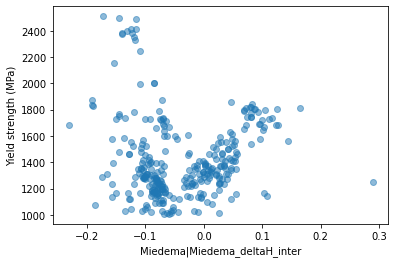

In [4]:
# Look at some of the top features chosen by MODNet
for feat in data.optimal_features[:10]:
    fig, ax = plt.subplots(facecolor="w")
    plt.scatter(data.df_featurized[feat], data.df_targets, alpha=0.5)
    plt.xlabel(feat)
    plt.ylabel("Yield strength (MPa)")

## Training

This is a very small dataset, so we must make judicious use of what data there is. First, let's generate test folds according to [matbench's suggestions](https://hackingmaterials.lbl.gov/automatminer/datasets.html#benchmarking-and-reporting-your-algorithm):

In [37]:
def benchmark(model, data, automatminer_target_mae=None, validation=False):
    import seaborn as sns
    predictions = model.predict(data)
    errors = np.abs(predictions.values - data.df_targets.values)
    fig, axes = plt.subplots(ncols=3, facecolor="w", figsize=(14, 4))
    
    ax = axes[0]
    ax.hist(errors, bins=100)
    name = model.target_names[0].split()[:-1]
    units = model.target_names[0].split()[-1].replace(")", "").replace("(", "")
    ax.set_ylabel("Frequency")
    ax.set_xlabel(f"Absolute error ({units})")
    if automatminer_target_mae is not None:
        ax.axvline(automatminer_target_mae, ls='--', color='k', label="Automatminer RF")
    if validation:
        ax.axvline(np.mean(model.history.history["val_mae"]), 0, 1, ls='--', color='r', label="Validation MAE")
    ax.axvline(np.mean(errors), ls='--', color='b', label="Test MAE")
    ax.legend()
    
    ax = axes[1]
    ax.scatter(data.df_targets.values, predictions.values, alpha=0.25, label=f"Test MAE: {np.mean(errors):3.1f} {units}")
    sns.regplot(x=data.df_targets.values, y=predictions.values, ax=ax)
    ax.set_xlabel(f"{name} true ({units})")
    ax.set_ylabel(f"{name} pred.({units})")
    ax.plot(np.linspace(*ax.get_xlim(), 2), np.linspace(*ax.get_xlim(), 2), label="true = pred.")
    ax.legend()
    
    ax = axes[2]
    if validation:
        ax.plot(model.history.history["val_mae"][10:])
        ax.set_ylabel(f"Validation MAE ({units})")
    else:
        ax.plot(model.history.history["mae"][10:])
        ax.set_ylabel(f"Test MAE ({units})")
    if automatminer_target_mae is not None:
        ax.axhline(automatminer_target_mae, ls='--', color="k", label="Automatminer RF")
    # ax.set_ylim(np.mean(errors)*0.5, np.mean(errors)*1.5)
    ax.set_xlabel("Epoch")
    
    plt.tight_layout()
    plt.show()
    
    return np.mean(errors)

INFO:root:Compiling model...
INFO:root:Fitting model...


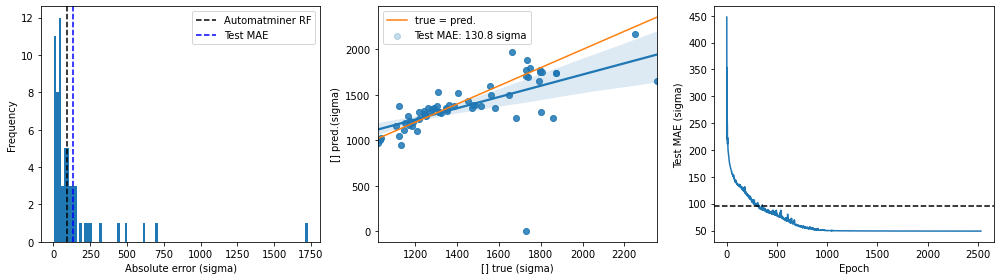

INFO:root:Compiling model...
INFO:root:Fitting model...


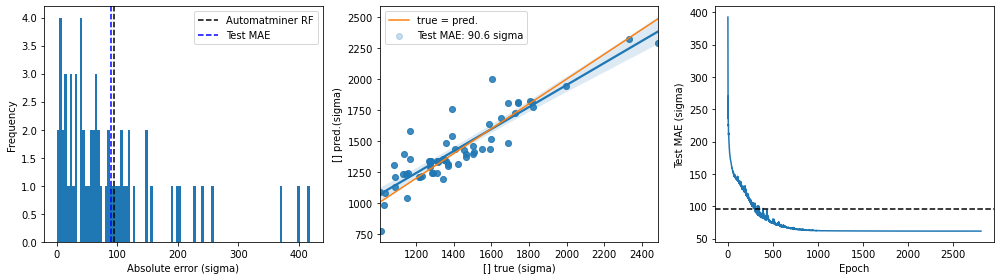

INFO:root:Compiling model...
INFO:root:Fitting model...


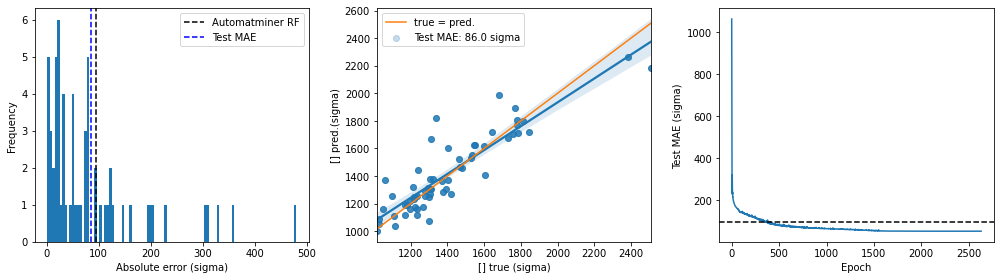

INFO:root:Compiling model...
INFO:root:Fitting model...


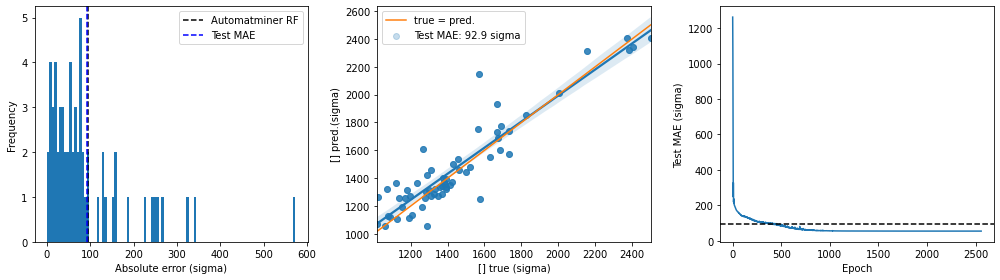

INFO:root:Compiling model...
INFO:root:Fitting model...


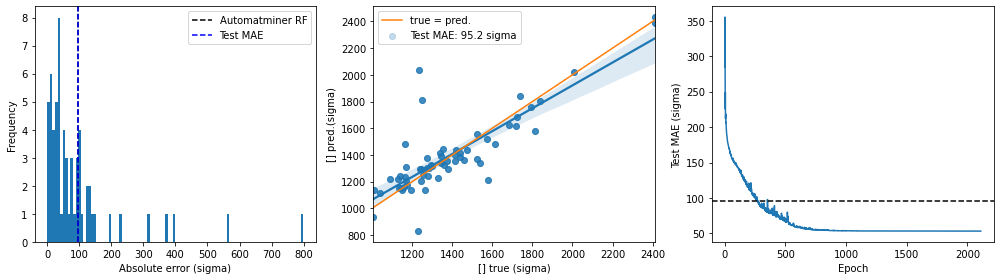

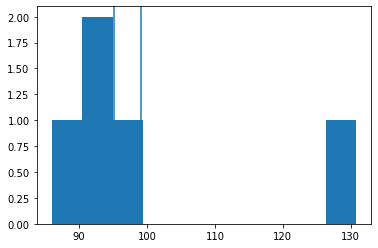

In [40]:
from sklearn.model_selection import KFold
from modnet.models import MODNetModel
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping

verbose = False

callbacks = [
    ReduceLROnPlateau(monitor="loss", factor=0.5, patience=20, mode="auto", min_delta=0.0, verbose=verbose), 
    EarlyStopping(monitor="loss", min_delta=0.01, patience=300, mode="auto", baseline=None, restore_best_weights=True, verbose=verbose)
]

# rename column as tf doesn't like puncutation/spaces
data.df_targets.rename(columns={"yield strength (GPa)": "sigma"}, inplace=True)

best_models = []
maes = []

for train, test in matbench_kfold_splits(data):
    
    train_moddata, test_moddata = data.split((train, test))
    
    model = MODNetModel(
        [[["sigma"]]], 
        {"sigma": 1}, 
        num_neurons=([64], [8], [8], []), 
        n_feat=64,
        act="elu",
    )
    model.fit(
        training_data=train_moddata, 
        batch_size=64, 
        epochs=5000, 
        # val_data=test_moddata,
        loss="mae",
        lr=0.01,
        verbose=0,
        callbacks=callbacks
    )
    
    best_models.append(model)
    mae = benchmark(model, test_moddata, 95.2)
    maes.append(mae)
    
plt.hist(maes)
plt.axvline(95.2)
plt.axvline(np.mean(maes))

99.10220262548464

In [4]:
model = MODNetModel(
    [[["sigma"]]], 
    {"sigma": 1}, 
)

bs = 64
lr = 0.01
archs = [
    (32, [[64], [8], [8], []]),
    (64, [[64], [8], [8], []]),
    (64, [[128], [64], [32], [8]]),
    (128, [[64], [8], [8], []]),
    (128, [[128], [64], [32], [8]]),
]
epochs = 5000
loss = "mae"
act = "elu"

data.df_targets.rename(columns={"yield strength (GPa)": "sigma"}, inplace=True)
presets = [dict(batch_size=bs, lr=lr, epochs=epochs, loss=loss, act=act, n_feat=a[0], num_neurons=a[1]) for a in archs]

In [5]:
model.fit_preset(data, presets=presets, verbose=0, xscale="standard")

INFO:root:Training preset #1/1
INFO:root:Compiling model...
INFO:root:Fitting model...
INFO:root:Validation loss: 172.128
INFO:root:Preset #1 resulted in lowest validation loss.
Fitting all data...


[<AxesSubplot:> <AxesSubplot:> <AxesSubplot:>]


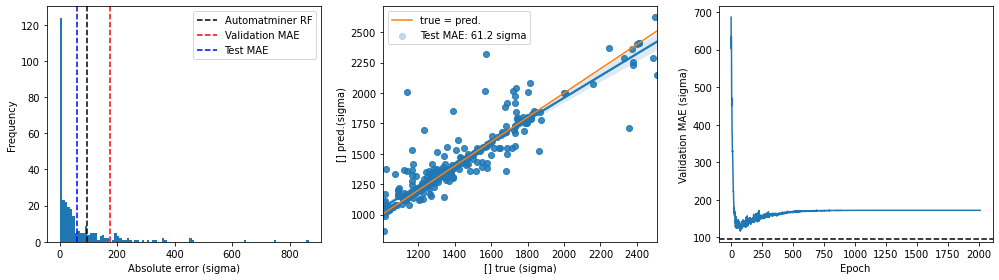

In [8]:
benchmark(model, data, 95.2)

In [9]:
def process(data):
    x = data.get_featurized_df()[model.optimal_descriptors[:model.n_feat]]
    x = model._scaler.transform(x)
    x = np.nan_to_num(x)
    return x

In [11]:
try:
    matbench_kfold_splits()
except:
    os.chdir("..")
    from modnet_matbench.utils import matbench_kfold_splits


In [14]:
import shap
shap.initjs()
for train, test in matbench_kfold_splits(data):
    train_moddata, test_moddata = data.split((train, test))
    break

X_train = shap.sample(process(train_moddata))
explainer = shap.KernelExplainer(model.model.predict, X_train)

In [15]:
shap_values = explainer.shap_values(X_train, nsamples=1000)

INFO:shap:num_full_subsets = 1
INFO:shap:remaining_weight_vector = [0.13786813 0.09341884 0.07123187 0.05795135 0.04912542 0.04284623
 0.03815993 0.03453666 0.03165861 0.02932358 0.02739687 0.02578529
 0.02442235 0.02325938 0.02225996 0.02139631 0.02064692 0.01999491
 0.01942687 0.01893206 0.01850178 0.018129   0.01780797 0.017534
 0.01730329 0.01711276 0.01695997 0.016843   0.01676044 0.01671129
 0.01669497]
INFO:shap:num_paired_subset_sizes = 31
INFO:shap:weight_left = 0.7851489242437005
INFO:shap:np.sum(w_aug) = 64.0
INFO:shap:np.sum(self.kernelWeights) = 1.0
INFO:shap:phi = [   0.          414.65343747    0.            0.           -3.14277336
  -14.92544546  -37.94030382 -101.93791315 -260.31668114  -26.5519104
    0.           27.67503554  -34.73380783   36.1570699     0.
    0.            0.            0.            0.            0.
    0.           22.04297238  -24.43727009    0.          -15.37858804
    0.           -8.01459861  -23.40939999  -14.31001831  -25.29549043
    0.

INFO:shap:num_full_subsets = 1
INFO:shap:remaining_weight_vector = [0.13786813 0.09341884 0.07123187 0.05795135 0.04912542 0.04284623
 0.03815993 0.03453666 0.03165861 0.02932358 0.02739687 0.02578529
 0.02442235 0.02325938 0.02225996 0.02139631 0.02064692 0.01999491
 0.01942687 0.01893206 0.01850178 0.018129   0.01780797 0.017534
 0.01730329 0.01711276 0.01695997 0.016843   0.01676044 0.01671129
 0.01669497]
INFO:shap:num_paired_subset_sizes = 31
INFO:shap:weight_left = 0.7851489242437005
INFO:shap:np.sum(w_aug) = 64.0
INFO:shap:np.sum(self.kernelWeights) = 0.9999999999999996
INFO:shap:phi = [131.83537684 -28.24821529   0.           0.          19.82152257
  47.76390287   0.           0.         118.42771826 -47.07188073
   0.           0.          63.31415602 -52.95483094   0.
   0.           0.          74.65857131  32.84438217 -38.05845529
   0.         -18.98957123  68.35529618 -44.66685406   6.99749389
   0.           0.           0.          19.99807643   0.
 -25.1875923   32.19

INFO:shap:num_full_subsets = 1
INFO:shap:remaining_weight_vector = [0.13786813 0.09341884 0.07123187 0.05795135 0.04912542 0.04284623
 0.03815993 0.03453666 0.03165861 0.02932358 0.02739687 0.02578529
 0.02442235 0.02325938 0.02225996 0.02139631 0.02064692 0.01999491
 0.01942687 0.01893206 0.01850178 0.018129   0.01780797 0.017534
 0.01730329 0.01711276 0.01695997 0.016843   0.01676044 0.01671129
 0.01669497]
INFO:shap:num_paired_subset_sizes = 31
INFO:shap:weight_left = 0.7851489242437005
INFO:shap:np.sum(w_aug) = 64.00000000000001
INFO:shap:np.sum(self.kernelWeights) = 1.0
INFO:shap:phi = [  0.         -24.16586655 -40.46447372   0.          -8.37767896
  17.13713283 -22.82106218  12.39449052 104.52226412 -41.50602667
  12.08265414  -5.99897486   0.          11.0815214   -7.90315658
  -4.68834983  -8.22237372  -4.9597072   -7.02297707 -12.47989346
 -10.04107476  40.18721084  58.01940654   7.38637319 -12.77354482
  -9.09724308  -8.27391784  19.09773575  13.43815948  19.25446264
   0. 

INFO:shap:num_full_subsets = 1
INFO:shap:remaining_weight_vector = [0.13786813 0.09341884 0.07123187 0.05795135 0.04912542 0.04284623
 0.03815993 0.03453666 0.03165861 0.02932358 0.02739687 0.02578529
 0.02442235 0.02325938 0.02225996 0.02139631 0.02064692 0.01999491
 0.01942687 0.01893206 0.01850178 0.018129   0.01780797 0.017534
 0.01730329 0.01711276 0.01695997 0.016843   0.01676044 0.01671129
 0.01669497]
INFO:shap:num_paired_subset_sizes = 31
INFO:shap:weight_left = 0.7851489242437005
INFO:shap:np.sum(w_aug) = 64.0
INFO:shap:np.sum(self.kernelWeights) = 1.0
INFO:shap:phi = [   0.          -35.14018182   17.47540735   -7.9024611    20.36494541
  -25.55404372  -77.94122806  -47.661869    126.43211157   -5.30007888
   -6.81806331    0.          116.2456073     0.          -15.73031086
    0.           -8.75705479  -18.94519097    0.          -18.7257187
  -27.05839143   46.71415422 -133.02355003  111.44560807  -32.50491899
  -27.31999632  -16.13294957  -31.21945506  -13.47135024  -56

INFO:shap:num_full_subsets = 1
INFO:shap:remaining_weight_vector = [0.13786813 0.09341884 0.07123187 0.05795135 0.04912542 0.04284623
 0.03815993 0.03453666 0.03165861 0.02932358 0.02739687 0.02578529
 0.02442235 0.02325938 0.02225996 0.02139631 0.02064692 0.01999491
 0.01942687 0.01893206 0.01850178 0.018129   0.01780797 0.017534
 0.01730329 0.01711276 0.01695997 0.016843   0.01676044 0.01671129
 0.01669497]
INFO:shap:num_paired_subset_sizes = 31
INFO:shap:weight_left = 0.7851489242437005
INFO:shap:np.sum(w_aug) = 64.0
INFO:shap:np.sum(self.kernelWeights) = 1.0
INFO:shap:phi = [  8.12317271 -22.96186791  14.84024508   0.         -10.04731242
  26.87119503  28.3012584   43.77911069  39.81892894 -28.31839038
   7.23494447 -22.67643682  -3.96803059   9.16834012  -6.62257767
  -9.58296605   0.          -6.87550309  -5.70848544  -4.32877563
  -8.59315151  -9.40058086  66.86728325 -28.65156314 -20.12398404
   5.78728188   0.          25.01513012   0.          21.82256719
   5.57788469 -19.9

INFO:shap:num_full_subsets = 1
INFO:shap:remaining_weight_vector = [0.13786813 0.09341884 0.07123187 0.05795135 0.04912542 0.04284623
 0.03815993 0.03453666 0.03165861 0.02932358 0.02739687 0.02578529
 0.02442235 0.02325938 0.02225996 0.02139631 0.02064692 0.01999491
 0.01942687 0.01893206 0.01850178 0.018129   0.01780797 0.017534
 0.01730329 0.01711276 0.01695997 0.016843   0.01676044 0.01671129
 0.01669497]
INFO:shap:num_paired_subset_sizes = 31
INFO:shap:weight_left = 0.7851489242437005
INFO:shap:np.sum(w_aug) = 64.0
INFO:shap:np.sum(self.kernelWeights) = 1.0
INFO:shap:phi = [   5.93429357  -24.8340689    18.59656456  -14.81558694  -23.28965173
  -22.6900588   -28.69016125   40.36396878   23.07828634   33.13904402
    0.          -25.44256985 -110.69297864    0.           -7.31401251
   27.83811532    0.            6.74709078   -3.15448396   33.82961835
  -21.13954859  -26.55014773  -61.52903738   90.54448687  -22.45308038
    0.            4.53717932   18.91727093    0.          -3

INFO:shap:num_full_subsets = 1
INFO:shap:remaining_weight_vector = [0.13786813 0.09341884 0.07123187 0.05795135 0.04912542 0.04284623
 0.03815993 0.03453666 0.03165861 0.02932358 0.02739687 0.02578529
 0.02442235 0.02325938 0.02225996 0.02139631 0.02064692 0.01999491
 0.01942687 0.01893206 0.01850178 0.018129   0.01780797 0.017534
 0.01730329 0.01711276 0.01695997 0.016843   0.01676044 0.01671129
 0.01669497]
INFO:shap:num_paired_subset_sizes = 31
INFO:shap:weight_left = 0.7851489242437005
INFO:shap:np.sum(w_aug) = 64.0
INFO:shap:np.sum(self.kernelWeights) = 1.0
INFO:shap:phi = [  29.08554184  -29.46751853    0.          -37.99875497  -53.22494401
  -39.61754813  274.29197144  -89.45180136 -109.7596776   -57.57200684
    0.           93.14073569  160.32034458  -65.87537721    0.
  -20.77724166  -25.76206612   40.92409642   65.406848    -24.7891403
   27.25345847  -19.70734634  -38.94138612 -103.87778506   77.45649373
   -6.52576099    0.            0.          -25.18137536  -41.6625982

INFO:shap:num_full_subsets = 1
INFO:shap:remaining_weight_vector = [0.13786813 0.09341884 0.07123187 0.05795135 0.04912542 0.04284623
 0.03815993 0.03453666 0.03165861 0.02932358 0.02739687 0.02578529
 0.02442235 0.02325938 0.02225996 0.02139631 0.02064692 0.01999491
 0.01942687 0.01893206 0.01850178 0.018129   0.01780797 0.017534
 0.01730329 0.01711276 0.01695997 0.016843   0.01676044 0.01671129
 0.01669497]
INFO:shap:num_paired_subset_sizes = 31
INFO:shap:weight_left = 0.7851489242437005
INFO:shap:np.sum(w_aug) = 64.0
INFO:shap:np.sum(self.kernelWeights) = 1.0
INFO:shap:phi = [   0.          -27.9491646    20.40096874    0.          -15.45203041
  -20.56689862   14.25537322   12.35115752  106.47523286  -37.94965485
   19.73944537  -33.62718204    0.           42.94434757    0.
    8.54659916   -7.4269927   -17.56734166    0.          -38.34356038
  -15.48837923   62.30167493   -6.31980849   68.44681925  -10.80521683
   15.07151039    0.            7.02169092  -16.79802894  -39.534064

INFO:shap:num_full_subsets = 1
INFO:shap:remaining_weight_vector = [0.13786813 0.09341884 0.07123187 0.05795135 0.04912542 0.04284623
 0.03815993 0.03453666 0.03165861 0.02932358 0.02739687 0.02578529
 0.02442235 0.02325938 0.02225996 0.02139631 0.02064692 0.01999491
 0.01942687 0.01893206 0.01850178 0.018129   0.01780797 0.017534
 0.01730329 0.01711276 0.01695997 0.016843   0.01676044 0.01671129
 0.01669497]
INFO:shap:num_paired_subset_sizes = 31
INFO:shap:weight_left = 0.7851489242437005
INFO:shap:np.sum(w_aug) = 64.00000000000001
INFO:shap:np.sum(self.kernelWeights) = 0.9999999999999996
INFO:shap:phi = [   0.          562.69493068    0.            0.            0.
    0.          -42.5764776   -28.97060708 -478.55813228  -38.10409663
    0.           56.06752102 -136.43609369    0.            0.
    0.            0.            0.            0.            0.
    0.            0.            0.          -83.75403171  -17.3932321
    0.            0.            0.            0.         

INFO:shap:num_full_subsets = 1
INFO:shap:remaining_weight_vector = [0.13786813 0.09341884 0.07123187 0.05795135 0.04912542 0.04284623
 0.03815993 0.03453666 0.03165861 0.02932358 0.02739687 0.02578529
 0.02442235 0.02325938 0.02225996 0.02139631 0.02064692 0.01999491
 0.01942687 0.01893206 0.01850178 0.018129   0.01780797 0.017534
 0.01730329 0.01711276 0.01695997 0.016843   0.01676044 0.01671129
 0.01669497]
INFO:shap:num_paired_subset_sizes = 31
INFO:shap:weight_left = 0.7851489242437005
INFO:shap:np.sum(w_aug) = 64.0
INFO:shap:np.sum(self.kernelWeights) = 1.0
INFO:shap:phi = [  38.73814782   -6.19968776  -32.00804321    0.          -43.38572776
   36.48178397  162.01633545   43.55042422 -195.50286348  -22.06324749
  -66.37015848  -18.77729891   -6.86614413  -21.95284586    6.73526881
   -7.03325623   22.95154772   21.97862008   -9.41044886   33.54430629
   -8.41705153 -115.01982034  129.21888416 -107.54186569  -39.20655062
   24.76298851    0.            0.            3.12454469   5

INFO:shap:num_full_subsets = 1
INFO:shap:remaining_weight_vector = [0.13786813 0.09341884 0.07123187 0.05795135 0.04912542 0.04284623
 0.03815993 0.03453666 0.03165861 0.02932358 0.02739687 0.02578529
 0.02442235 0.02325938 0.02225996 0.02139631 0.02064692 0.01999491
 0.01942687 0.01893206 0.01850178 0.018129   0.01780797 0.017534
 0.01730329 0.01711276 0.01695997 0.016843   0.01676044 0.01671129
 0.01669497]
INFO:shap:num_paired_subset_sizes = 31
INFO:shap:weight_left = 0.7851489242437005
INFO:shap:np.sum(w_aug) = 64.00000000000001
INFO:shap:np.sum(self.kernelWeights) = 0.9999999999999996
INFO:shap:phi = [   0.          203.32931767   20.44134809   18.22069876  -24.30901348
   -6.48089331  -89.39438389 -125.75231401   11.26196541   40.58267591
  -10.31868611    0.          198.9423429   -11.37804509    0.
   -4.17822199   15.18812682  -28.3710366    62.60344314  -14.56317409
    0.           -8.0330247  -107.44495852   51.6776187    -6.97480262
  -18.05548808  -12.48494261  -21.014326

INFO:shap:num_full_subsets = 1
INFO:shap:remaining_weight_vector = [0.13786813 0.09341884 0.07123187 0.05795135 0.04912542 0.04284623
 0.03815993 0.03453666 0.03165861 0.02932358 0.02739687 0.02578529
 0.02442235 0.02325938 0.02225996 0.02139631 0.02064692 0.01999491
 0.01942687 0.01893206 0.01850178 0.018129   0.01780797 0.017534
 0.01730329 0.01711276 0.01695997 0.016843   0.01676044 0.01671129
 0.01669497]
INFO:shap:num_paired_subset_sizes = 31
INFO:shap:weight_left = 0.7851489242437005
INFO:shap:np.sum(w_aug) = 64.0
INFO:shap:np.sum(self.kernelWeights) = 0.9999999999999996
INFO:shap:phi = [  0.         -36.43068524  15.28650842  -6.82688665  18.95342793
 -23.9302726  -44.4232555  -52.82848363 125.73051191  26.00227406
  -9.89412999   0.          36.34816744   0.         -13.26551879
  13.00242145 -18.59981112 -21.97811185   0.          12.71393331
 -26.41662215  40.44703124 -99.88064414  91.50063012 -27.219279
  -9.89658465 -13.84102987 -24.80372698 -13.29085056 -42.99456277
   0. 

INFO:shap:num_full_subsets = 1
INFO:shap:remaining_weight_vector = [0.13786813 0.09341884 0.07123187 0.05795135 0.04912542 0.04284623
 0.03815993 0.03453666 0.03165861 0.02932358 0.02739687 0.02578529
 0.02442235 0.02325938 0.02225996 0.02139631 0.02064692 0.01999491
 0.01942687 0.01893206 0.01850178 0.018129   0.01780797 0.017534
 0.01730329 0.01711276 0.01695997 0.016843   0.01676044 0.01671129
 0.01669497]
INFO:shap:num_paired_subset_sizes = 31
INFO:shap:weight_left = 0.7851489242437005
INFO:shap:np.sum(w_aug) = 64.0
INFO:shap:np.sum(self.kernelWeights) = 1.0
INFO:shap:phi = [   0.          -37.7423633     0.           44.14464475   84.11284604
    0.           22.66292347    0.          -60.92104305   92.29971551
   39.04126323    0.           19.90355594    0.           35.68069043
    0.            0.            0.          -45.32808296    0.
   48.67234639    0.          -59.91115577  -94.04243193  130.30342423
    0.            0.            0.            0.           87.770688

INFO:shap:num_full_subsets = 1
INFO:shap:remaining_weight_vector = [0.13786813 0.09341884 0.07123187 0.05795135 0.04912542 0.04284623
 0.03815993 0.03453666 0.03165861 0.02932358 0.02739687 0.02578529
 0.02442235 0.02325938 0.02225996 0.02139631 0.02064692 0.01999491
 0.01942687 0.01893206 0.01850178 0.018129   0.01780797 0.017534
 0.01730329 0.01711276 0.01695997 0.016843   0.01676044 0.01671129
 0.01669497]
INFO:shap:num_paired_subset_sizes = 31
INFO:shap:weight_left = 0.7851489242437005
INFO:shap:np.sum(w_aug) = 64.00000000000001
INFO:shap:np.sum(self.kernelWeights) = 0.9999999999999996
INFO:shap:phi = [  32.42145907  -18.24578841  -28.59679184    0.          -34.48353194
   23.02768632  159.73105511   38.17226682 -199.55678341  -20.47982377
  -62.25780145  -21.51077405    0.          -22.52948119   12.81668974
  -13.3548412    19.37979993   20.69362157    0.           29.53767659
   -7.38854829 -116.40343909  129.98126337  -94.12191705  -29.98686707
   32.24971448    0.            

INFO:shap:num_full_subsets = 1
INFO:shap:remaining_weight_vector = [0.13786813 0.09341884 0.07123187 0.05795135 0.04912542 0.04284623
 0.03815993 0.03453666 0.03165861 0.02932358 0.02739687 0.02578529
 0.02442235 0.02325938 0.02225996 0.02139631 0.02064692 0.01999491
 0.01942687 0.01893206 0.01850178 0.018129   0.01780797 0.017534
 0.01730329 0.01711276 0.01695997 0.016843   0.01676044 0.01671129
 0.01669497]
INFO:shap:num_paired_subset_sizes = 31
INFO:shap:weight_left = 0.7851489242437005
INFO:shap:np.sum(w_aug) = 64.0
INFO:shap:np.sum(self.kernelWeights) = 1.0
INFO:shap:phi = [ -12.99320321  -16.13204505   20.35330473   -2.03172236   -5.07674023
   24.26167643  -21.81803146   41.15504861   71.98288438  -41.43987063
  -12.52637956   13.29933763 -129.50868714   34.57718618  -13.43861122
  -10.01939243   -4.63918027  -13.97523063   -1.75668005   19.56250095
   11.90720272   17.15027962   56.38001419  -22.53958499  -17.0224177
    0.            9.49856735    6.35325946   -1.83199503   37

INFO:shap:num_full_subsets = 1
INFO:shap:remaining_weight_vector = [0.13786813 0.09341884 0.07123187 0.05795135 0.04912542 0.04284623
 0.03815993 0.03453666 0.03165861 0.02932358 0.02739687 0.02578529
 0.02442235 0.02325938 0.02225996 0.02139631 0.02064692 0.01999491
 0.01942687 0.01893206 0.01850178 0.018129   0.01780797 0.017534
 0.01730329 0.01711276 0.01695997 0.016843   0.01676044 0.01671129
 0.01669497]
INFO:shap:num_paired_subset_sizes = 31
INFO:shap:weight_left = 0.7851489242437005
INFO:shap:np.sum(w_aug) = 64.0
INFO:shap:np.sum(self.kernelWeights) = 1.0
INFO:shap:phi = [  5.52875395 -23.78191874 -52.64312545   0.           0.
  21.92475697 -20.75325703   0.          91.41950722 -47.29684141
   9.40286986   0.         -56.99130789  17.91990976   0.
   0.          -7.77144362   0.           0.           0.
   0.          32.97240457  47.42133831   0.         -12.25472631
   0.           0.           9.92303575  10.38243363  11.38378032
   9.68549102 -17.05681418 -17.93505976   0

INFO:shap:num_full_subsets = 1
INFO:shap:remaining_weight_vector = [0.13786813 0.09341884 0.07123187 0.05795135 0.04912542 0.04284623
 0.03815993 0.03453666 0.03165861 0.02932358 0.02739687 0.02578529
 0.02442235 0.02325938 0.02225996 0.02139631 0.02064692 0.01999491
 0.01942687 0.01893206 0.01850178 0.018129   0.01780797 0.017534
 0.01730329 0.01711276 0.01695997 0.016843   0.01676044 0.01671129
 0.01669497]
INFO:shap:num_paired_subset_sizes = 31
INFO:shap:weight_left = 0.7851489242437005
INFO:shap:np.sum(w_aug) = 64.00000000000001
INFO:shap:np.sum(self.kernelWeights) = 0.9999999999999996
INFO:shap:phi = [ 18.21941903 -35.35473728  17.18882065 -20.53511508 -12.83127554
  16.50621033 -33.91513026  42.29132205 171.14673643 -42.59298835
  13.64504561 -20.01907955 142.11721282   0.         -14.33837368
 -12.89776389  -2.31056283  15.54647572  20.57042327 -57.56160805
 -23.69241763  47.71592058  28.36244317   5.33688852 -31.88882775
 -18.31134987 -15.40963227  19.91149352   0.         -22.

In [22]:
shap.force_plot(
    explainer.expected_value, 
    shap_values[0], 
    feature_names=model.optimal_descriptors[:model.n_feat], 
    out_names=["Yield strength (GPa)"],
)

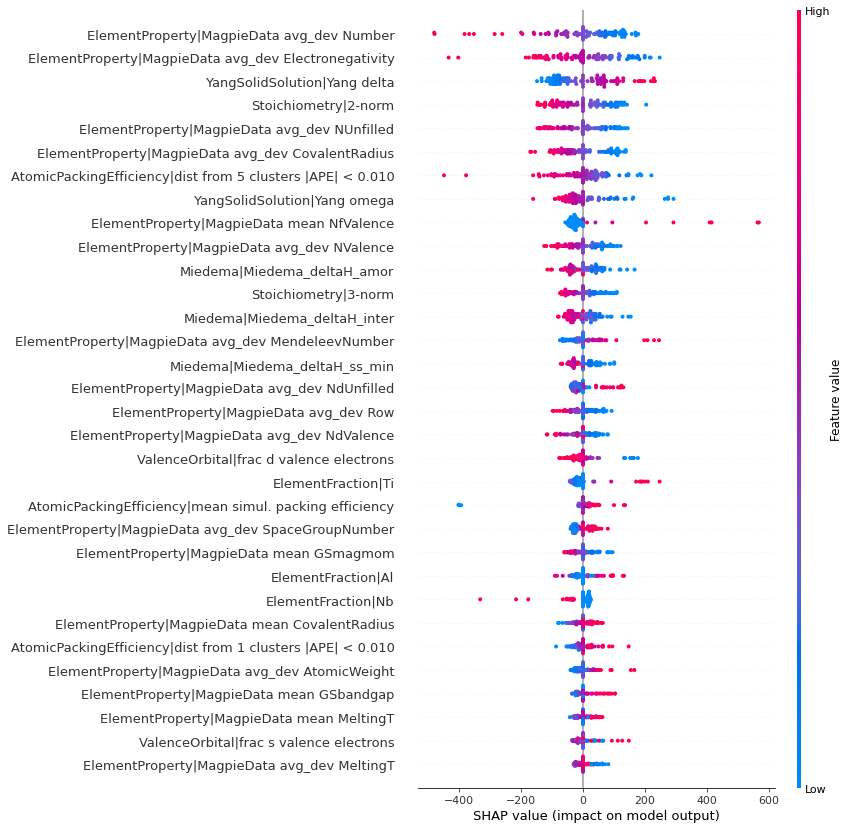

In [24]:
shap.summary_plot(shap_values[0], X_train, max_display=32, plot_type="dot", feature_names=model.optimal_descriptors[:model.n_feat])

In [64]:
data.df_featurized.columns[22]

'ElementProperty|MagpieData range Number'

In [25]:
model.optimal_descriptors[:model.n_feat]

['AtomicPackingEfficiency|mean simul. packing efficiency',
 'ElementProperty|MagpieData mean NfValence',
 'ElementFraction|Nb',
 'ElementProperty|MagpieData minimum Column',
 'AtomicPackingEfficiency|dist from 1 clusters |APE| < 0.010',
 'ElementProperty|MagpieData avg_dev SpaceGroupNumber',
 'YangSolidSolution|Yang omega',
 'AtomicPackingEfficiency|dist from 5 clusters |APE| < 0.010',
 'ElementProperty|MagpieData avg_dev Number',
 'Miedema|Miedema_deltaH_inter',
 'ElementProperty|MagpieData avg_dev Column',
 'ValenceOrbital|frac s valence electrons',
 'ElementProperty|MagpieData avg_dev Electronegativity',
 'ElementProperty|MagpieData mean NdUnfilled',
 'ElementProperty|MagpieData mean AtomicWeight',
 'ElementProperty|MagpieData mean Electronegativity',
 'ElementProperty|MagpieData mean NpUnfilled',
 'ElementProperty|MagpieData mean GSvolume_pa',
 'ElementFraction|Mo',
 'ElementProperty|MagpieData mean GSmagmom',
 'ElementProperty|MagpieData avg_dev MeltingT',
 'ElementProperty|Magpie

In [43]:
bs = 64
lr = 0.01
archs = [
    (64, [[64], [8], [8], []]),
    (64, [[64], [32], [8], [8]]),
    (64, [[128], [64], [32], [8]]),
]

epochs = 5000
loss = "mae"
act = "elu"

data.df_targets.rename(columns={"yield strength (GPa)": "sigma"}, inplace=True)
presets = [dict(batch_size=bs, lr=lr, epochs=epochs, loss=loss, act=act, n_feat=a[0], num_neurons=a[1]) for a in archs]

In [46]:
#nested fit preset
for train, test in matbench_kfold_splits(data):
    
    train_moddata, test_moddata = data.split((train, test))
    
    for train, val in matbench_kfold_splits(train_moddata):
        sub_train_moddata, val_moddata = data.split((train, val))
    
        model = MODNetModel(
            [[["sigma"]]], 
            {"sigma": 1}, 
        )

        model.fit_preset(sub_train_moddata, presets=presets, val_data=val_moddata)
        best_models.append(model)

INFO:root:Training preset #1/3
INFO:root:Compiling model...
INFO:root:Fitting model...
INFO:root:Validation loss: 206.024
INFO:root:Training preset #2/3
INFO:root:Compiling model...
INFO:root:Fitting model...
INFO:root:Validation loss: 176.804
INFO:root:Training preset #3/3
INFO:root:Compiling model...
INFO:root:Fitting model...
INFO:root:Validation loss: 167.829
INFO:root:Preset #3 resulted in lowest validation loss.
Fitting all data...
INFO:root:Training preset #1/3
INFO:root:Compiling model...
INFO:root:Fitting model...
INFO:root:Validation loss: 192.912
INFO:root:Training preset #2/3
INFO:root:Compiling model...
INFO:root:Fitting model...
INFO:root:Validation loss: 174.845
INFO:root:Training preset #3/3
INFO:root:Compiling model...
INFO:root:Fitting model...
INFO:root:Validation loss: 149.554
INFO:root:Preset #3 resulted in lowest validation loss.
Fitting all data...
INFO:root:Training preset #1/3
INFO:root:Compiling model...
INFO:root:Fitting model...
INFO:root:Validation loss: 17

INFO:root:Training preset #3/3
INFO:root:Compiling model...
INFO:root:Fitting model...
INFO:root:Validation loss: 177.622
INFO:root:Preset #3 resulted in lowest validation loss.
Fitting all data...
INFO:root:Training preset #1/3
INFO:root:Compiling model...
INFO:root:Fitting model...
INFO:root:Validation loss: 200.124
INFO:root:Training preset #2/3
INFO:root:Compiling model...
INFO:root:Fitting model...
INFO:root:Validation loss: 161.745
INFO:root:Training preset #3/3
INFO:root:Compiling model...
INFO:root:Fitting model...
INFO:root:Validation loss: 173.052
INFO:root:Preset #2 resulted in lowest validation loss.
Fitting all data...
INFO:root:Training preset #1/3
INFO:root:Compiling model...
INFO:root:Fitting model...
INFO:root:Validation loss: 170.078
INFO:root:Training preset #2/3
INFO:root:Compiling model...
INFO:root:Fitting model...
INFO:root:Validation loss: 166.507
INFO:root:Training preset #3/3
INFO:root:Compiling model...
INFO:root:Fitting model...
INFO:root:Validation loss: 16

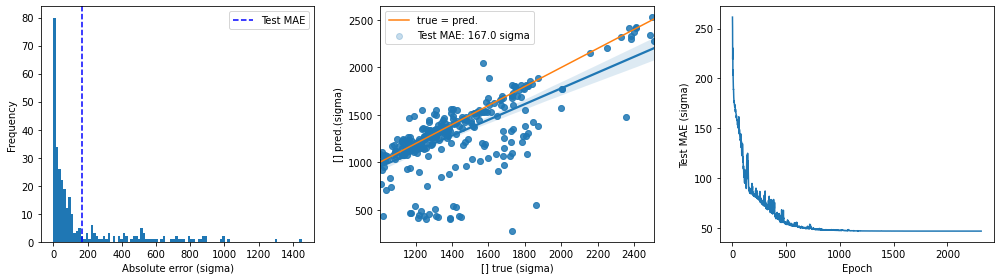

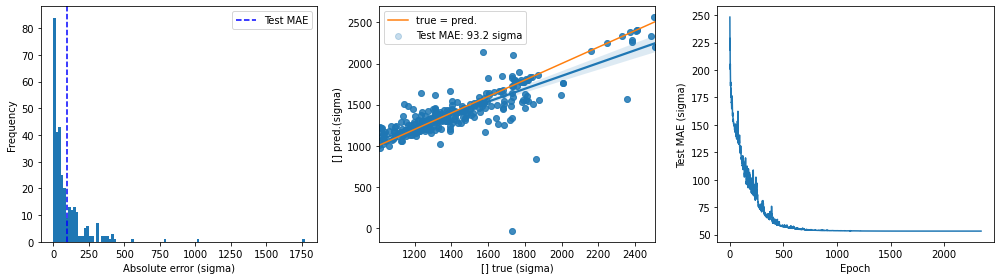

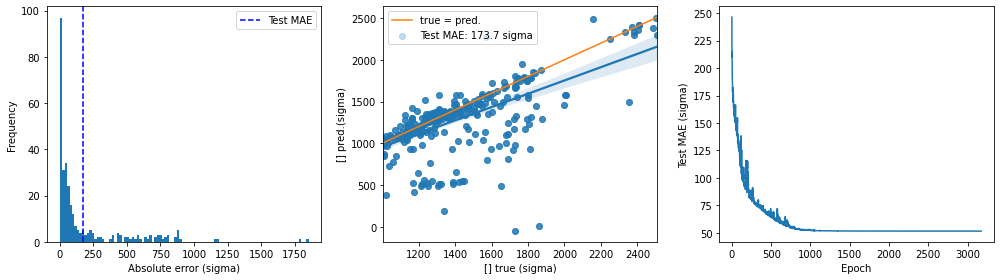

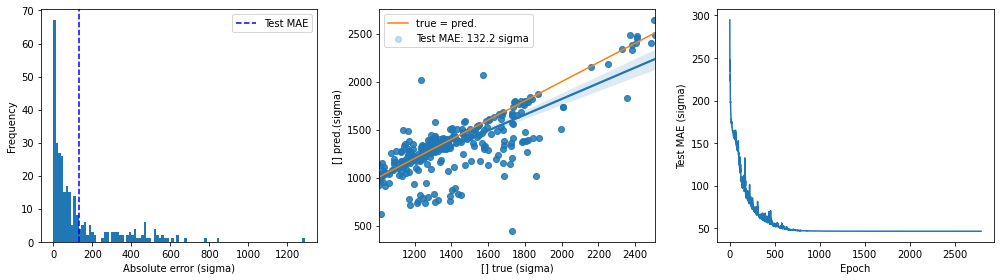

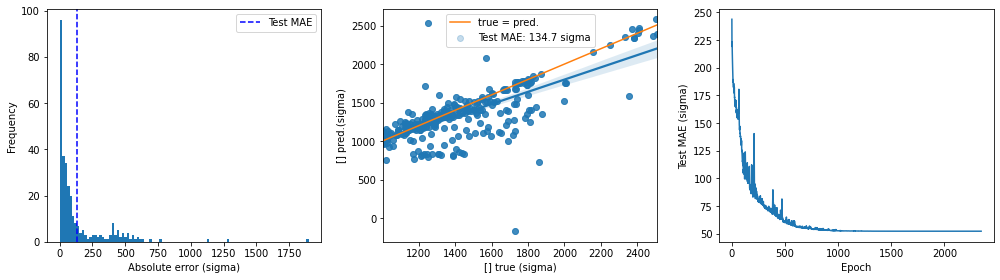

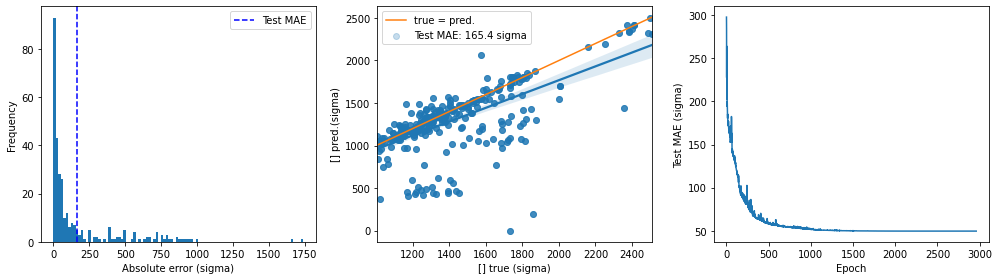

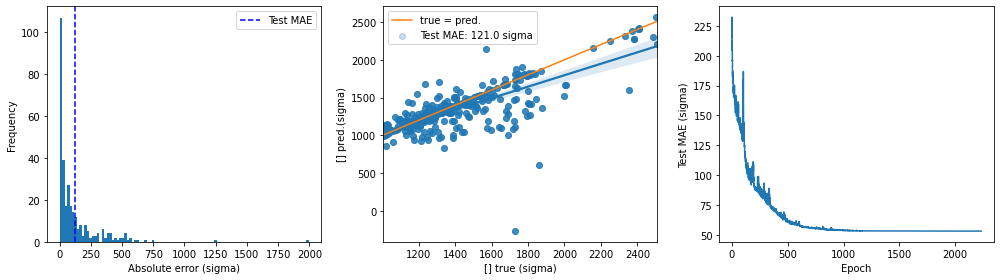

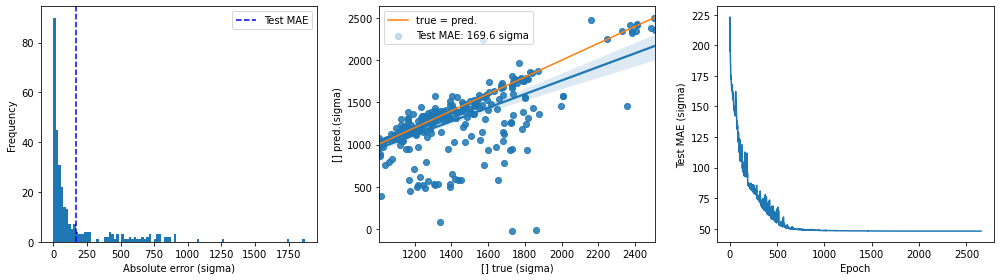

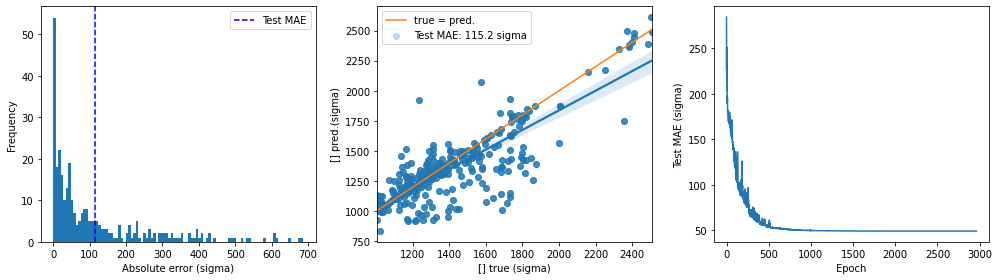

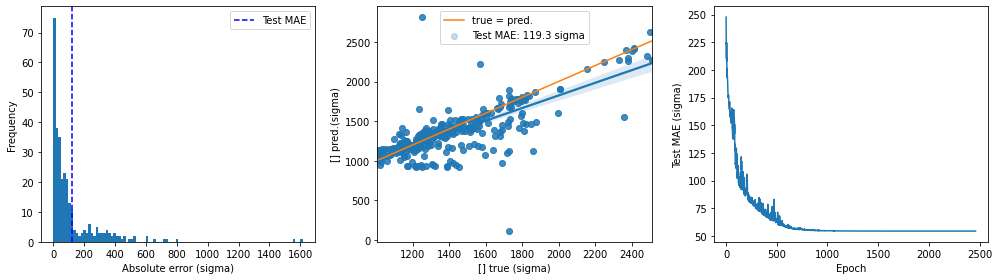

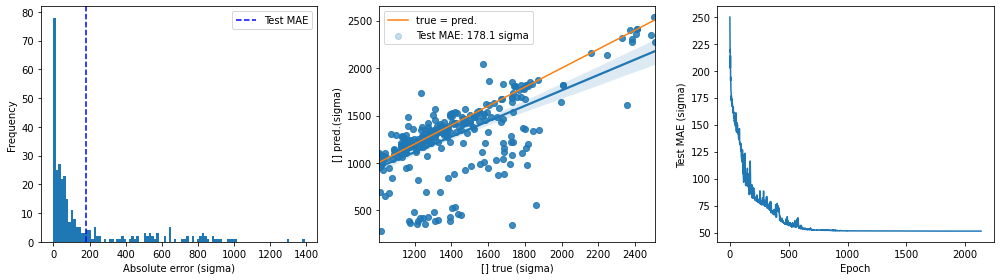

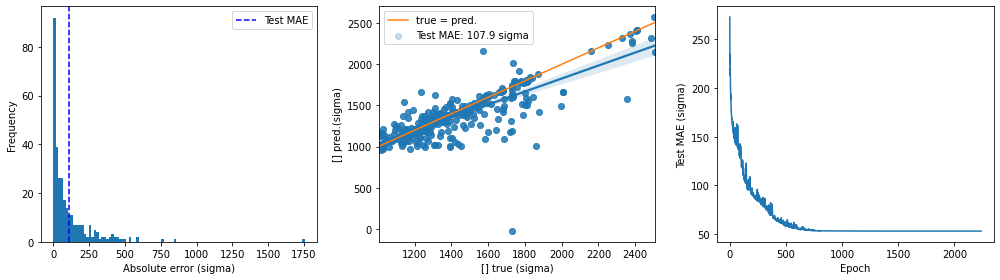

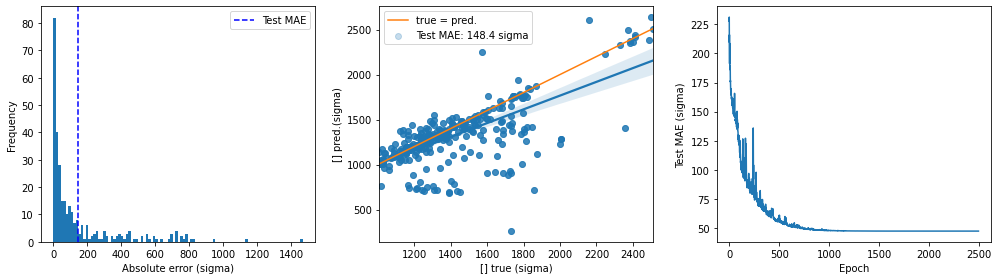

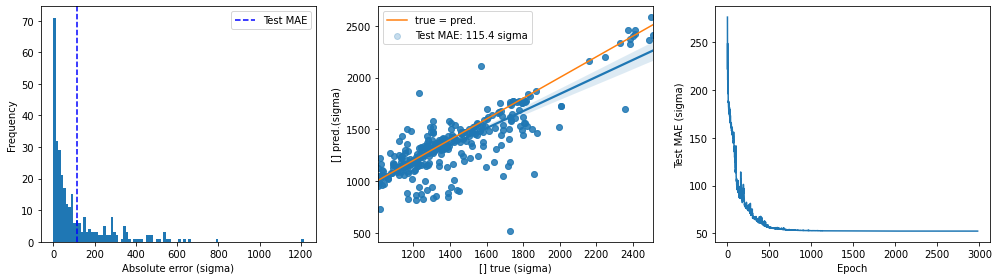

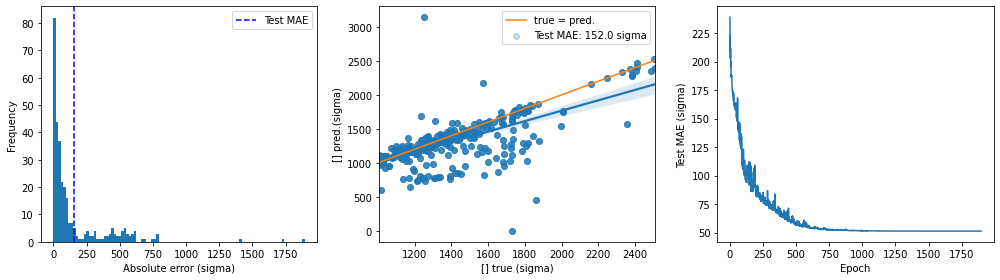

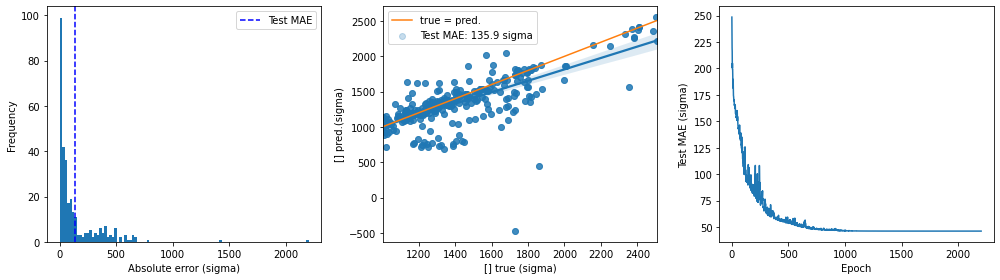

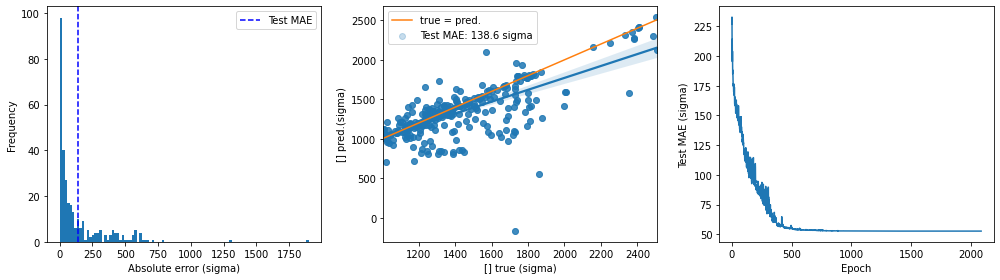

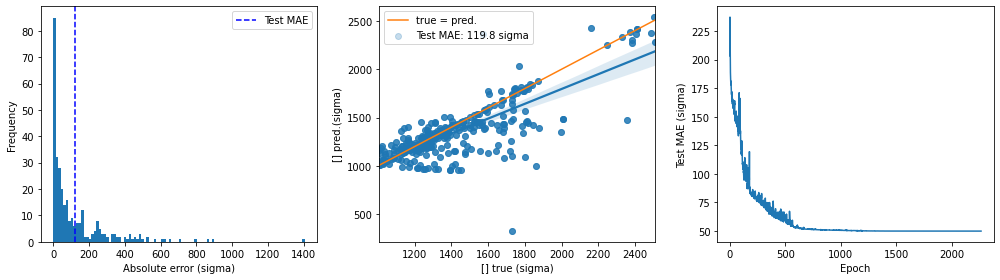

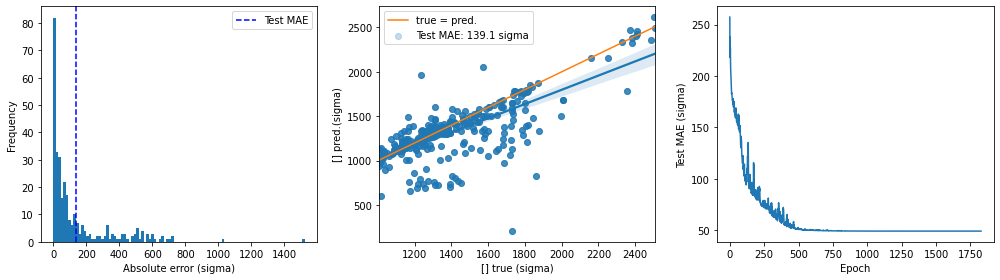

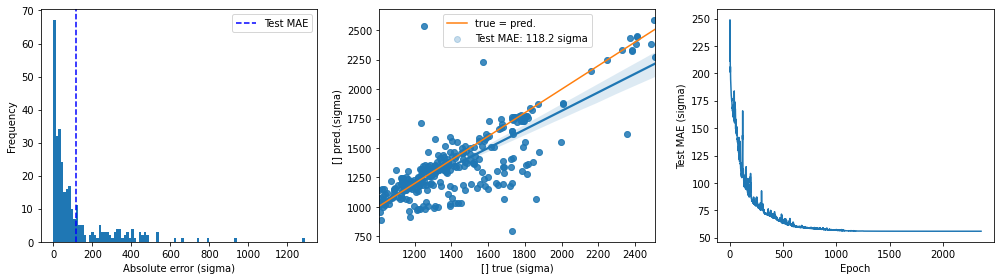

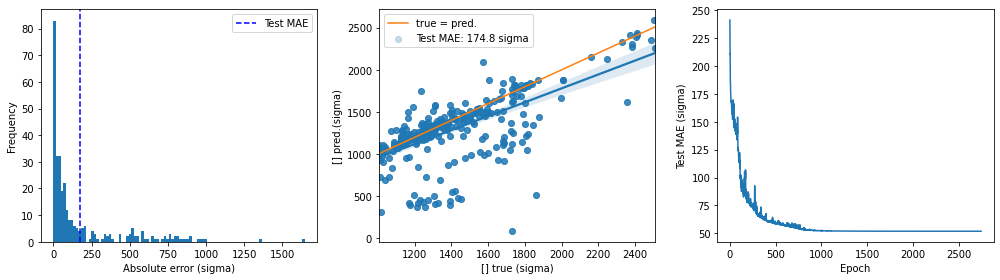

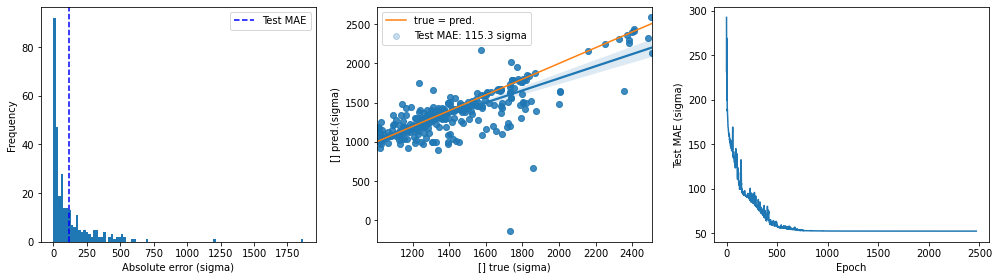

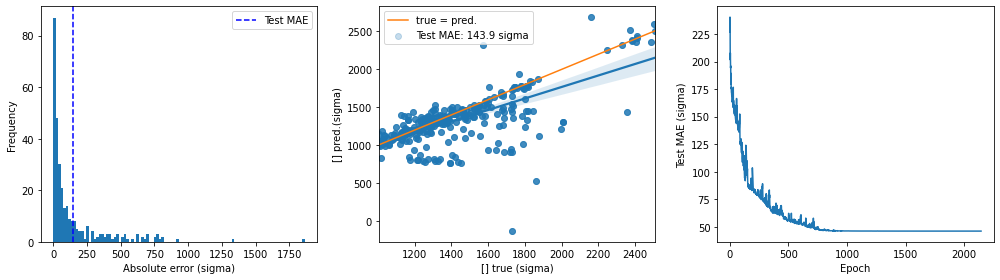

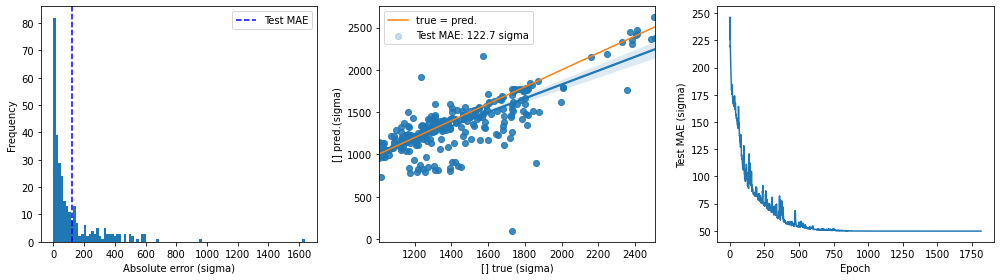

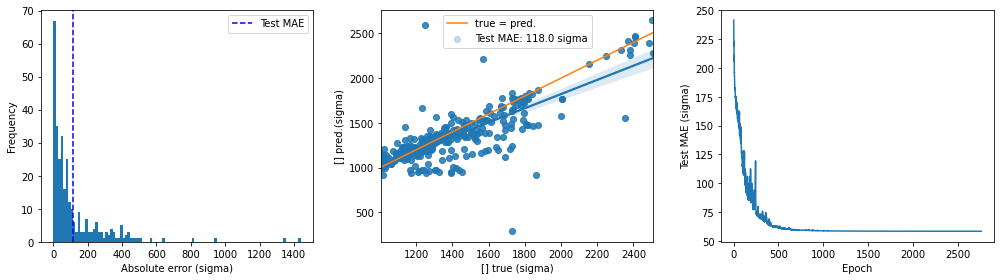

In [50]:
for i in range(25):
    benchmark(best_models[i+5], data)